In [5]:
import numpy as np
import math
from Crypto.Util.number import getPrime, inverse, bytes_to_long, long_to_bytes
import random

In [6]:
def isqrt(n):
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x

def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a%b)

def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        gcd, x, y = egcd(b%a, a) #compute gcd first
        return (gcd, y - b//a *x , x)

# A congruential public key cryptosystem

Alice:  
* Choose large integer mod $q$
* choose secret $f, g$ with $f<\sqrt{q/2}, \sqrt{q/4} < g < \sqrt{q/2}$ and $\gcd(f, qg) = 1$
* Compute $h \equiv f^{-1}g  \ mod \ q$
* Publish $(q, h)$

Encryption (Bob):
* choose plaintext $m$ with $m<\sqrt{q/4}$
* choose random $r < \sqrt{q/2}$
* Compute $e \equiv rh + m \ mod \ q$
* Send e

Decryption (Alice):
* Compute $a \equiv fe \ mod \ q $ with $ 0 < a < q$
* Compute $b \equiv f^{-1}e \ mod \ q $ with $ 0 < b < g$
* Then $b = m$

Proof:
$b = f^{-1}e \equiv f^{-1}(rg + fm) \equiv f^{-1}fm \equiv m \ mod \ g $ with $0 < b < g$

### Example

In [7]:
def make_keys():
    #alice chooses
    q = 122430513841
    f = 231231
    g = 195698
    assert (f < isqrt(q//2))
    assert (isqrt(q//4) < g < isqrt(q//2))
    
    h = (inverse(f, q) * g) % q
    return (q, h), (f, g)
    
    

In [8]:
(q, h), (f, g) = make_keys()

In [9]:
def encrypt(q, h, m):
    assert(m < isqrt(q//4)), 'Message too long'
    r = random.randint(0, isqrt(q//2))
    
    e = (r*h + m) % q

    return e

In [10]:
m = 123456
e = encrypt(q, h, m)

In [11]:
def decrypt(e, q, h, f, g):
    a = (f*e) % q
    b = (inverse(f, g) * a) % g
    
    return b
    

In [12]:
b = decrypt(e, q, g, f, g)

In [13]:
b

123456

In [14]:
b == m

True

### Where are the lattices tho?

Try to find $(f, g)$ from $(q, h)$ => find $(F, G): Fh \equiv G \ mod \ q$ where $F, G  = \mathcal{O}(\sqrt{q}) <=> $  
$<=>\begin{align*} Fh &= G + qR  \\ F &= F + 0 \end{align*}<=> 
F \begin{bmatrix} 1 \\ h \end{bmatrix} - R \begin{bmatrix} 0 \\ q \end{bmatrix} = \begin{bmatrix} F \\ G \end{bmatrix}$

so $v1 = \begin{bmatrix} 1 \\ h \end{bmatrix}$, $v2 = \begin{bmatrix} 0 \\ q \end{bmatrix}$, $w = \begin{bmatrix} F \\ G \end{bmatrix}$

=> find a linear combination $w =a_1v_1 + a_2v_2$  =>   
=> Find shortest vector in the set $L = \{a_1v_1 + a_2v_2 | a_1, a_2 \in \mathbb{Z}\}$ =  two dimensional **lattice**


# Subset-sum problems

**Subset-Sum Problem**

Suppose that you are given a list of positive integers $(M_1,M_2,...,M_n)$ and another integer $S$. Find a subset of the elements in the list whose sum is S. (You may assumethat there is at least one such subset.)



*Proposition*  
Let $M = (M_1,M_2,...,M_n)$, $(M,S)$ = Subset-sum problem  
For all sets $I \subset\{i | \ 1 \leq i \leq n/2\}$ and $J \subset\{j | \ n/2 < j \leq n\}$ compute and make a list of values
$A_I = \sum_{i\in I}M_i$ and $B_J = S - \sum_{j \in J}M_j$

Then $\exists (I_0, J_0)$ with $A_{I_0} = B_{J_0}$ => $S = \sum_{i\in I}M_i + \sum_{j \in J}M_j$

From here we might create a collision algorithm that breaks the system in $\mathcal{O}(2^{n/2})$

**Superincreasing Sequence**

$r=(r_1,r_2,...,r_n)$ with the property that $r_i+1 ≥ 2r_i$ for all $1≤i≤n−1$.

### Algorithm for $(M, S)$

In [11]:
list_M = [3,11,24,50,115]
S = 142
def superSM(list_M, S):
    list_x = []
    for M_i in reversed(list_M):
        if S>=M_i:
            list_x.append(1)
            S-=M_i
        else:
            list_x.append(0)
    return list(reversed(list_x))
            
    

In [12]:
xs = superSM(list_M, S)

In [13]:
xs

[1, 0, 1, 0, 1]

In [14]:
print(S == sum([m * x for (m, x) in zip(list_M, xs)]))

True


### Cryptosystem based on superincreasing seq (Merkle and Hellman)

Key creation(Alice):
* Choose superincreasing $r=(r_1,...,r_n)$
* Choose $A$ and $B$ with $B>2r_n$ and $\gcd(A, B)=1$
* Compute $M_i=Ar_i(modB)$ for $1≤i≤n $
* Publish the public key $M=(M1,...,Mn)$

Encryption(Bob):
* Choose plaintext $x$
* $S = x * M$
* Send S

Decryption (Alice):
* $S' \equiv A^{-1}S \ mod \ B$
* solve $(S', r)$ => $x$

Proof:
$S' \equiv A^{-1}S \equiv A^{-1} \sum^n_{i = 1}x_iAr_i \equiv \sum^n_{i = 1}x_ir_i \ mod \ b$

In [5]:
def create_key_MH():
    r = [3,11,24,50,115]
    A = 113
    B = 250
    M = [A * r_i % B for r_i in r]
    return M, (r, A, B)

In [16]:
M, (r, A, B) = create_key_MH()

In [17]:
x = [1,0,1,0,1]
def encrypt_MH(M, x):
    S = sum([x_i * M_i for (x_i, M_i) in zip(x, M)])
    return S

In [18]:
S = encrypt_MH(M, x)

In [19]:
def decrypt_MH(r, A, B, S):
    S_prime = inverse(A, B)*S % B
    x = superSM(r, S_prime)
    
    return x

In [20]:
x_decrypted = decrypt_MH(r, A, B, S)

In [21]:
x_decrypted == x

True

Some observations make this algorithm impractical
* we need $r_1 > 2^n$ => $r_n > 2^{2n} => B>2r_n = 2^{2n+1} => M_i = \mathcal{O}(2^{2n}) ; S = \mathcal{O}(2^{2n})$
* Big public key: for $n = 160 => 2n^2 = 51200$ bits (Ex: DH: 1k bits)
* weak to LLL

### The lattice please

Suppose you want to write $S$ as a subset-sum from the set $M = (m_1, ...,m_n)$. Consider the matrix

$\begin{bmatrix}
2&0&\dots&0&m_1 \\ 
2&0&\dots&0&{m_2} \\
\vdots&\vdots&\ddots&\vdots&\vdots \\
0&0&\dots&2&m_n \\
1&1&\dots&1&S
\end{bmatrix} => 
\begin{align*}
v_1&=(2,0,0,...,0,m_1) \\ 
v_2&=(0,2,0,...,0,m_2) \\
&\vdots \ \vdots \\
v_n&=(0,0,0,...,2,m_n) \\
v_{n+1}&=(1,1,1,...,1,S)
\end{align*} \Bigg{\}}=> 
L=\{a_1v_1+a_2v_2+···+a_nv_n+a_{n+1}v_{n+1} \ | \ a_1,a_2,...,a_{n+1}∈ \mathbb{Z}\} $



Suppose $x = (x_1, x_2, ... x_n)$ is a solution => L contains  
$t = \sum^n_{i=1}x_iv_i - v_{n+1} = (2x_1 -1, 2x_2 -1, \dots, 2x_n -1, 0)$

Last coord of $t$ is 0 because $S = x_1m_1 + \dots + x_nm_n$

$x_i \in {0, 1} => t_i \in {-1, 1} => \|t\| = \sqrt{n} = $  __short__  
since $m_i = \mathcal{O}(2^{2n}); S = \mathcal{O}(2^{2n})$ => is likely that $t$ is the shortest vector => LLL 



# Vector space recap

I'll just assume you know the basics. I'll put only concept names

* Linear combinations
* Independence
* Basis that spans a vector space


**Prop 1**  
Let $v_1,...,v_n$ be a basis for $V$ and let $w_1,...,w_n$ be another set of $n$ vectors in $V$ .Write each $w_j$ as a linear combination of the $v_i$

$\begin{align*}  
w_1 &= α_{11}v_1+α_{12}v_2+···+α_{1n}v_n \\
w_2&=α_{21}v_1+α_{22}v_2+···+α_{2n}v_n \\
\vdots \ \vdots \\
w_n&=α_{n1}v_1+α{n2}v_2+···+α_{nn}v_n
\end{align*}
$

=> Then $w_1,..., w_n$ is also a **basis** for $V$ <=>
$\det(A) = 
\begin{vmatrix}
α_{11}&α_{12}&···&α_{1n}\\
α_{21}&α_{22}&···&α_{2n}\\
\vdots &\vdots&\ddots &\vdots \\
α_{n1} & α_{n2}&···&α_{nn}
\end{vmatrix} \neq 0$

* dot product; $v*w = 0 => v \perp w $
* norm; $\|v\|^2 = v * v$
* angle $ \cos(\theta) =\frac{v*w}{\|v\| * \|w\|}$
* Cauchy Schwartz $|v * w| \leq \|v\| * \|w\| $
* **orthogonal basis** => $v=a_1v_1+···+a_nv_n => ‖v‖^2=‖a_1v_1+···+a_nv_n‖^2$ where $v_1,...,v_n$ = orthogonal basis 
* orthonormal basis


**Gram schmidt algorithm** = basis => orthogonal basis

In [125]:
def Gram_Schmidt(v):
    vo = np.zeros(v.shape)
    miu = np.zeros(v.shape)
    vo[0] = v[0]
    for i in range(1, v.shape[0]):
        for j in range(i):
            miu[i][j] = v[i].dot(vo[j]) / v[j].dot(v[j])
        vo[i] = v[i] - sum([miu[i][j] * v[j] for j in range(i)])
        
    return vo
        

In [126]:
v1 = [1, 2]; v2 = [2, 3]
v = np.array([v1, v2])

In [127]:
vo = Gram_Schmidt(v)

In [128]:
print(vo[0].dot(vo[1])) #which is basically 0

-4.440892098500626e-16


# Lattices

Let $v_1,...,v_n$ be a set of linear independent vectors. Then  
$L = \{a_1v_1 +...+ a_nv_n | a_1,..., a_n \in \mathbb{Z}\}$

* $\dim L = n$

we try the same as **Prop 1** =>  
$1 = \det(I) = \det(AA^{−1}) = \det(A)\det(A^{-1})$ where $\det(A), \det(A^{-1}) \in \mathbb{Z} => \det(A) = \pm1$

**Prop 2**  
Any two bases for a lattice $L$ are related by a matrix having integer coefficients and determinant equal to $±1$

**Fundamental domain** 

Let $L$ be a lattice of dimension $n$ and let $v_1,v_2,...,v_n$ be a basis for $L$. The **fundamental domain** for $L$ corresponding to this basis is the set  
$\mathcal{F}(v_1,...,v_n)=\{t_1v_1+t_2v_2+···+t_nv_n:0≤t_i<1\}$.

=> Every vector $w∈R^n$ can be written in the form $w=t+v$ for a **unique** $t∈\mathcal{F}$ and a **unique** $v∈L$.

Equivalently, the union of the translated fundamental domains $F+v={t+v:t∈F}$ exactly covers $Rn$

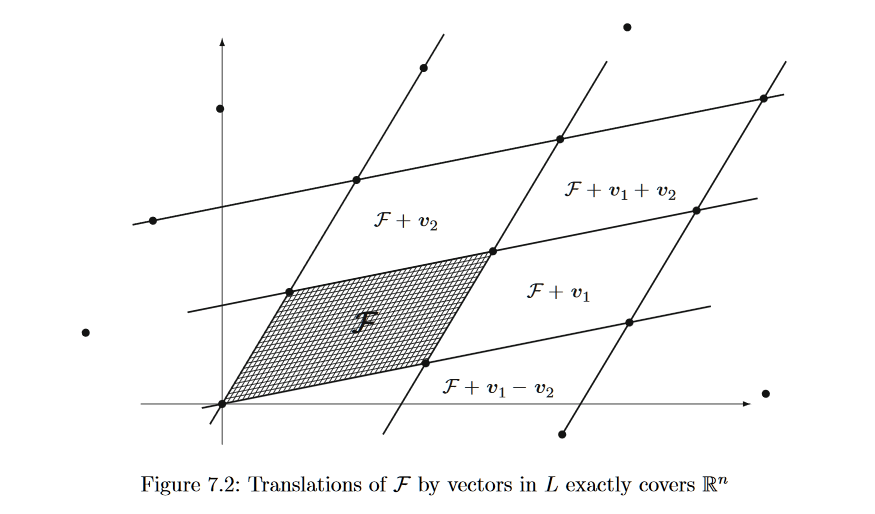

* $\det(L) = \det(F)$ where $F =$ the coordinate matrix of $\mathcal{F}(v_1,...,v_n)$

*Hadamard's inequality*  
$\det(L) = \text{Vol}(\mathcal{F}) \leq \|v_1\|*...*\|v_n\|$

* $\forall \ \mathcal{F} $ for $L => \text{Vol}\mathcal{F} = \text{const}$ <=> every fundamental domain for L has the same volume => **INVARIANT**

# Short vectors in lattices

## Problems



* **Shortest vector problem (SVP)**  
Find $v \in L$ that minimizes $||v||$

* **Closest vector problem (CVP)**  
Given $w \in \mathbb{R}^m; \  w\notin L$ find $v \in L$ that minimizes $||w-v||$

* **Shortest basis problem (SBP)**  
Given $L$ find a basis $\{v_1, ..., v_n\}$ that is "shortest" in some sense  
Ex: $\underset{1 \leq i \leq n}{\max}||v_i||$ or $\sum_{i = 1}^n ||v||^2$



* **ApprSVP**  
Let $\psi(n) = function$ where $n = \dim L$ Find $v$ such that $||v|| \leq \psi(n)||v_{shortest}||$
* **ApprCVP**   
same idea

**Minkowski theorem**:  
Let $L \subset \mathbb{R}^n, \dim L = n; S \subset \mathbb{R}^n, S = $bounded symmetrical convex set whose volume satisfies   
$\text{Vol}(S) > 2^n\det(L)$  
Then S contains a nonzero lattice vector

watch 12 mins for intuition
https://www.youtube.com/watch?v=tZx7K0Or70Y&list=PLgKuh-lKre12CuCYPwpfH77-K6U_3JweQ



# Babai's algorithm

**Remark**  
if L has an orthogonal basis => SVP and CVP are easy:
* SVP: the vector is found in the basis
* CVP:
$\begin{align*}
w&=t_1v_1+t_2v_2+···+t_nv_n \text{with} \ t_1,...,t_n∈\mathbb{R}. \\
v&=a_1v_1+···+a_n \ v_n∈L
\end{align*} \Big \}
‖v−w‖^2=(a_1−t_1)^2‖v_1‖^2+(a_2−t_2)^2‖v_2‖^2+···+(a_n−t_n)^2‖v_n‖^2 => 
$

=>we take $a_i$ to be the closest integer to $t_i$


For a near-orthogonal base this might work

But if you have a bad base, shit like this might happen:
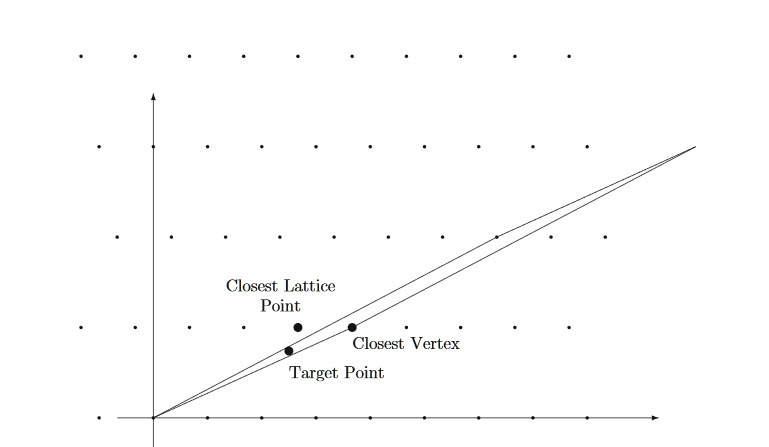

Intuition:  
Find a translation $(\mathcal{F} + v)$ that contains $w$ and take the closest vertex  
$w=v+\epsilon_1v_1+\epsilon_2v_2+···+\epsilon_nv_n$ with $\epsilon \in \{0, 1\}$


**Hadamards ratio**   
$\mathcal{H}(\mathcal{B}) = \left( \frac{\det L}{||v_1||*\dots*||v_n||} \right) ^{1/n} \in (0, 1]$

The closest this value is to 1, the more orthogonal the vectors are

In [195]:
### Example

In [196]:
def hadamards_ratio(v):
    '''vectors are columns'''
    H = (np.abs(np.linalg.det(v)) / np.prod([np.linalg.norm(v_i) for v_i in v.T])) ** (1/v.shape[1])
    return H

In [186]:
v1 = np.array((137, 312)) 
v2 = np.array((215, -187))
v = np.array([v1, v2]).T
w= np.array((53172,81743))

In [190]:
h = hadamards_ratio(v)
print(h)

0.9770939601963543


In [135]:
#solve w = t1v1 + t2v2
t = np.linalg.solve(v, w)
print(t1, t2)

296.8522745660687 58.15459713697019


In [136]:
v @ t

array([53172., 81743.])

In [197]:
def babai(v, w):
    '''Vectors must be columns'''
    t = np.linalg.solve(v, w)
    assert np.all(np.round(v @ t) == w)
    t_round = np.round(t)
    cv = v @ t_round
    return cv
    

In [210]:
cv = babai(v, w)
print(cv)

[53159. 81818.]


In [211]:
np.linalg.norm(cv - w)

76.11832893594026

In [212]:
### now let's try in not so orthogonal basis

In [213]:
v1_prime = np.array((1975,438))
v2_prime = np.array((7548,1627))
v_prime = np.array([v1_prime, v2_prime]).T

In [214]:
print(hadamards_ratio(v_prime))

0.07703608694278126


In [217]:
cv_prime = babai(v_prime, w)
print(cv_prime)
print(np.linalg.norm(cv_prime - w))

[56405. 82444.]
3308.124846495368


# GGH Cryptosystem

Key creation (Alice):
* Choose a good basis $V = \{v_1, \dots, v_n\}$
* Choose integer matrix $U$ with $\det(U) = \pm1$
* Compude a bad basis $W = \{w_1, ... ,w_n\} = UV$
* Publish $W$

Encryption (Bob):
* choose small plaintext vector $m$
* choose random small vector $r$
* $e = m_1w_1 + ... + x_nw_n + r$
* Send $e$

Decryption (Alice):
* Use Babai's algo to compute the closest vector $v\in L$ to $e$
* $v*W^{-1} = m$

An alternative version of GGH reverses the roles of $m$ and $r$,so the ciphertext has the form $e=rW+m$.  
Alice finds $rW$ by computing the lattice vector closest to $e$, and then she recovers the plaintext as $m=e−rW$

In [203]:
def GGH_key_creation(d, n):
    '''
    d = parameter to compute the good base,
    n =dimension
    vectors are columns
    '''
    #creating the good base V
    while True:
        V = np.array([np.random.randint(-d, d, n) for _ in range(n)]).T
        if hadamards_ratio(V) > .95:
            break
            
    #creating U; 
    #U can be a random product of elementary matrices
    #U is a product of two triangular matrices with diagonals +-1 
    while True:
        l = np.tril(np.random.randint(-d, d, size=(n,n)))
        u = np.triu(np.random.randint(-d, d, size=(n,n)))
        for i in range(0, n):
            l[i, i] = np.random.choice([-1, 1])
            u[i, i] = np.random.choice([-1, 1])
        U = u @ l
        W = V @ U
        if hadamards_ratio(W) < .02:
            break
    return V, W
        
    #random elementary operations 
    #return v
                     
                 

In [204]:
v, w = GGH_key_creation(100, 3)

In [205]:
hadamards_ratio(v), hadamards_ratio(w)

(0.9699032801518386, 0.0008539653760172945)

In [206]:
def GGH_encryption(m, w):
    r = np.random.randint(10, size = len(m))
    e = w.dot(m) + r
    return e

In [207]:
m = np.array((100, 200, 300))

In [208]:
e = GGH_encryption(m, w)

In [209]:
def GGH_decryption(v, w, e):
    cv = babai(v, e)
    #print(cv)
    return np.round(np.linalg.inv(w) @ cv).astype(int)
    

In [210]:
m_decr = GGH_decryption(v, w, e)

In [211]:
m_decr, m_decr == m

(array([100, 200, 300]), array([ True,  True,  True]))

In [488]:
#Suppose Eve wanted to break it

In [489]:
eve_decr = GGH_decryption(w, w, e) #Eve has acces only to W

In [490]:
eve_decr

array([   -30,  11765, 680060])

In [491]:
#Lets look at how close they are

In [494]:
np.linalg.norm(e - babai(v, e)), np.linalg.norm(e - babai(w, e)) #big difference

(5.0990195135927845, 150012.22393858442)

# GO TO THE SAGE NB FOR NTRU ENCRYPT

and come back when you're told

# Breaking stuff

we remake the algorithms in python

In [100]:
def gram_s(v):
    v = v.copy()
    n = v.shape[0]
    m = v.shape[1]
    v_s = np.zeros((n, m), dtype = object)
    mu = np.zeros((n, m), dtype = object)
    v_s[0] = v[0]
    for i in range(1, n):
        for j in range(i):
            mu[i, j] = v[i].dot(v_s[j]) / v_s[j].dot(v_s[j])
        v_s[i] = v[i] - sum([mu[i,j] * v_s[j] for j in range(0, i)])
        
    return v_s, mu
        

In [101]:
v1=np.array((1,3,2))
v2=np.array((4,1,-2))
v3=np.array((2,1,3))
v = np.array((v1, v2, v3))

In [102]:
v_s, mu = gram_s(v)
v_s, mu

(array([[1, 3, 2],
        [3.7857142857142856, 0.3571428571428572, -2.4285714285714284],
        [1.094736842105263, -1.3684210526315792, 1.505263157894737]],
       dtype=object),
 array([[0, 0, 0],
        [0.21428571428571427, 0, 0],
        [0.7857142857142857, 0.03157894736842112, 0]], dtype=object))

In [103]:
def gaussian_lattice_reduction(v1, v2):
    while True:
        if v2.dot(v2) < v1.dot(v1):
            v1, v2 = v2, v1
        #print(v1.dot(v2), v1.dot(v1))
        m = np.round(v1.dot(v2) / v1.dot(v1))
        if m == 0:
            return v1, v2
        v2 = v2 - m*v1   

In [104]:
v1= np.array((66586820,65354729), dtype = np.ulonglong)
v2= np.array((6513996,6393464), dtype = np.ulonglong)

gaussian_lattice_reduction(v1,v2)

(array([ 2280., -1001.]), array([-1324., -2376.]))

In [137]:
def lenstra_lenstra_lovasz(v):    
    v = v.copy()
    n = v.shape[0]
    v_s, mu= gram_s(v)
    k = 1
    while k < n:
        for j in range(k-1, -1, -1):
            #size condition
            if abs(mu[k, j]) > 1/2:
                v[k] = v[k] - np.round(mu[k, j]) * v[j]
                v_s, mu= gram_s(v)
        
        #print(v_s)
        #Lovasz condition
        if np.linalg.norm(v_s[k])**2 > (3/4 - np.round(mu[k, k-1])**2) * np.linalg.norm(v_s[k-1])**2 :
            k = k+1
        else:
            v[k-1], v[k] = v[k].copy(), v[k-1].copy() #holy shit I lost 1 hour because I forgot to copy here
            v_s, mu= gram_s(v)
            k = max(k-1, 1)
    return v

In [138]:
#dtype object for large numbers
M = np.array([
    [19, 2,32, 46, 3, 33],
    [15, 42, 11,  0,  3, 24],
    [43, 15,  0, 24,  4, 16], 
    [20, 44, 44,  0, 18, 15], 
    [0, 48 ,35, 16, 31, 31], 
    [48, 33, 32, 9, 1, 29]
], dtype = object)

M_lll = lenstra_lenstra_lovasz(M)
print(M_lll)

[[-7.0 12.0 8.0 -4.0 -19.0 -9.0]
 [-20.0 4.0 -9.0 16.0 13.0 16.0]
 [6.0 7.0 20.0 21.0 -8.0 12.0]
 [-28.0 11.0 12.0 -9.0 17.0 -14.0]
 [-10.0 -24.0 21.0 -15.0 -6.0 -11.0]
 [-7.0 -4.0 9.0 11.0 -1.0 -31.0]]



## congruential

$v_1 = [1, h], v_2 = [0, q]$

In [146]:
(q, h), (f, g) = make_keys()

v1 = np.array([1, h],dtype = object)
v2 = np.array([0, q], dtype = object)
vs1, vs2 = gaussian_lattice_reduction(v1, v2)
print(vs1, vs2)

[-231231.0 -195698.0] [-368222.0 217835.0]


In [148]:
f == -vs1[0], g ==-vs1[1]

(True, True)

## Knapsacks

In [169]:
list_M = [89,243,212,150,245, 546]
n = len(list_M)
S = 546

In [170]:
A_ms = np.zeros((n, n))
for i in range(n):
    A_ms[i, i] = 2
    A_ms[n-1, i] = 1
    A_ms[i, n-1] = list_M[i]

In [171]:
A_ms

array([[  2.,   0.,   0.,   0.,   0.,  89.],
       [  0.,   2.,   0.,   0.,   0., 243.],
       [  0.,   0.,   2.,   0.,   0., 212.],
       [  0.,   0.,   0.,   2.,   0., 150.],
       [  0.,   0.,   0.,   0.,   2., 245.],
       [  1.,   1.,   1.,   1.,   1., 546.]])

In [184]:
A_ms_lll = lenstra_lenstra_lovasz(A_ms)

In [185]:
A_ms_lll

array([[-1.,  1., -1.,  1., -1.,  0.],
       [ 1., -1., -1.,  1., -1., -1.],
       [-1., -1., -1.,  1.,  1.,  2.],
       [-1.,  1.,  1.,  1.,  1., -2.],
       [-2., -2.,  4.,  0., -2.,  0.],
       [-6., -4., -6., -6.,  0., -3.]])

In [192]:
v0 = A_ms_lll[0]
print('first vector', v0)
sol = np.round(np.linalg.solve(A_ms.T, v0))
print('solution', sol)
print(sum(sol * list_M)) #m = first n-1 terms


first vector [-1.  1. -1.  1. -1.  0.]
solution [-1. -0. -1. -0. -1.  1.]
0.0


## GGH

In [234]:
#we use column vectors but I implemented LLL with row vectors so we transpose a bit

In [239]:
v, w = GGH_key_creation(100, 3)
m = np.array((100, 200, 300))
e = GGH_encryption(m, w)
m_decr = GGH_decryption(v, w, e)

In [240]:
hadamards_ratio(v), hadamards_ratio(w)

(0.9873949128769718, 0.0006318179859544252)

In [241]:
w_lll = lenstra_lenstra_lovasz(w.T).T #transpose for row, w_lll will be row so we transpose again

In [242]:
hadamards_ratio(w_lll)

0.9873949128769718

In [243]:
cv = babai(w_lll, e)
cv

array([ 3.940190e+07,  1.409665e+08, -9.799310e+07])

In [247]:
m_eve = np.round(np.linalg.solve(w, cv))
print(m_eve)
print(m_eve == m)

[100. 200. 300.]
[ True  True  True]


# GO TO THE SAGE NB FOR NTRU 

# TO DO 
* Efficient LLL
* Babai's closest plane
* NTRUDSA